IMPORTS, LOADING, AND PREPROCESSING

In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# check PyTorch and GPU setup
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch Version: 2.5.1+cu124
CUDA Available: True
GPU Name: NVIDIA L4


In [3]:
# preprocessing transformation
# convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(),
                                ])

In [5]:
# load cifar-10 dataset
# partition into train and test sets
trainset=torchvision.datasets.CIFAR10(
    root='./data',
    train=True, # load training set (50k images)
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False, # load test set (10k images)
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# create dataloaders
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=False)

In [7]:
# inspect data
dataiter = iter(train_loader) # iterator to grab batch
images, labels = next(dataiter) # get first batch
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)
print("Image value range:", images.min().item(), "to", images.max().item())

Batch of images shape: torch.Size([4, 3, 32, 32])
Batch of labels shape: torch.Size([4])
Image value range: 0.0 to 0.9215686321258545


In [8]:
# define class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


VERIFY AND VISUALIZE DATA

In [9]:
# check full dataset range
all_images = torch.stack([img for img, _ in trainset]) # stacks all 50k training images
print("Full training set value range:", all_images.min().item(), "to", all_images.max().item())

Full training set value range: 0.0 to 1.0


In [10]:
# function to visualize images
def show_images(images, labels, class_names, num_images=4):
  plt.figure(figsize=(10,3))
  for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    # permute tensor from [3, 32, 32] to [32, 32, 3] for display
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
  plt.show()

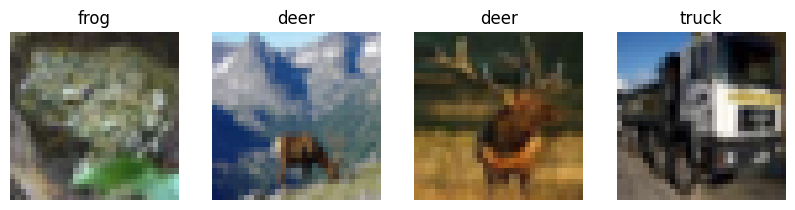

In [11]:
# grab a batch and visualize
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels, class_names, num_images=4)

GENERATING PAIRS FOR SIAMESE NETWORK

In [12]:
# import dataset class
from torch.utils.data import Dataset

# define custom siamese dataset class
class SiameseCIFAR10Dataset(Dataset):
  def __init__(self, dataset, num_pairs_per_class=200):
    self.dataset = dataset # cifar-10 dataset
    self.num_pairs_per_class = num_pairs_per_class
    self.num_classes = 10
    # unzip images and labels from dataset
    self.images, self.labels = zip(*[(img, lbl) for img, lbl in dataset])
    self.labels = torch.tensor(self.labels) # convert labels to tensor
    self.pairs, self.pair_labels = self._generate_pairs() # create pairs

  def _generate_pairs(self):
    pairs = []
    pair_labels = []
    import numpy as np # for random sampling

    # generate positive pairs (same class)
    for class_idx in range(self.num_classes):
      # find indices of images in class
      class_indices = (self.labels == class_idx).nonzero(as_tuple=True)[0]
      # check if enough images for pairs
      if len(class_indices) < 2:
        continue
      # generate pairs
      for _ in range(self.num_pairs_per_class):
        idx1, idx2 = np.random.choice(class_indices, 2, replace=False)
        pairs.append([self.images[idx1], self.images[idx2]])
        pair_labels.append(1)

    # generate negative pairs (diff. class)
    for _ in range(self.num_pairs_per_class * self.num_classes):
      # pick 2 different classes
      class1, class2 = np.random.choice(self.num_classes, 2, replace=False)
      idx1= np.random.choice((self.labels == class1).nonzero(as_tuple=True)[0])
      idx2 = np.random.choice((self.labels == class2).nonzero(as_tuple=True)[0])
      pairs.append([self.images[idx1], self.images[idx2]])
      pair_labels.append(0)

    return pairs, torch.tensor(pair_labels, dtype=torch.float32)

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    img1, img2 = self.pairs[idx] # get the 2 images
    label = self.pair_labels[idx] # get label
    return img1, img2, label


In [13]:
# create Siamese dataset
siamese_trainset = SiameseCIFAR10Dataset(trainset, num_pairs_per_class=200)

# batch the pairs w/ DataLoader
train_loader = DataLoader(siamese_trainset, batch_size=4, shuffle=True)

In [15]:
# check a batch
dataiter = iter(train_loader)
img1, img2, labels = next(dataiter)
print("Image 1 batch shape:", img1.shape)
print("Image 2 batch shape:", img2.shape)
print("Labels shape:", labels.shape)
print("Total pairs:", len(siamese_trainset))

Image 1 batch shape: torch.Size([4, 3, 32, 32])
Image 2 batch shape: torch.Size([4, 3, 32, 32])
Labels shape: torch.Size([4])
Total pairs: 4000
